In [37]:
# Step 1: Import libraries
import os
import wfdb
import pandoc
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report

In [38]:
base_path = "/Users/mohithreddy/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"

In [39]:
zip_path = "/Users/mohithreddy/Downloads/apnea-ecg-database-1.0.0.zip"  # change if needed
extract_dir = "/Users/mohithreddy/apnea-ecg-database-1.0.0"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted to:", extract_dir)
print("Files inside:", os.listdir(extract_dir)[:10])

Extracted to: /Users/mohithreddy/apnea-ecg-database-1.0.0
Files inside: ['apnea-ecg-database-1.0.0']


In [40]:
os.getcwd()

'/Users/mohithreddy'

In [41]:
os.listdir("apnea-ecg-database-1.0.0")[:10]

['apnea-ecg-database-1.0.0']

In [42]:
# Adjust path one level deeper
data_path = "apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"

In [43]:
os.listdir(data_path)[:10]

['a02er.xws',
 'c08.dat',
 'x12.hea',
 'x06.hea',
 'a04.hea',
 'a10.hea',
 'a04.apn',
 'a10.apn',
 'x34.dat',
 'c06.hea']

In [44]:
data_path = "/Users/mohithreddy/Downloads/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"

In [45]:
data_path = "apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"

# Select 5 subjects
subjects = ['a04', 'a06', 'b05', 'a08', 'c10']
records = {}
for subj in subjects:
    record_path = os.path.join(data_path, subj)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'apn') # apnea annotations
    records[subj] = {
        "signal": record.p_signal[:, 0],
        "fs": record.fs,
        "annotations": annotation.sample,
        "labels": annotation.symbol
    }
    print(f"{subj}: Loaded with {len(record.p_signal)} samples at {record.fs},Hz.")

a04: Loaded with 2980000 samples at 100,Hz.
a06: Loaded with 3058000 samples at 100,Hz.
b05: Loaded with 2593500 samples at 100,Hz.
a08: Loaded with 3002500 samples at 100,Hz.
c10: Loaded with 2585000 samples at 100,Hz.


In [46]:

# FILTERING ECG SIGNALS

from scipy.signal import butter, filtfilt

def bandpass_filter(ecg_signal, fs, lowcut=0.5, highcut=40, order=4):
    """Apply bandpass filter to remove noise and baseline drift."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, ecg_signal)

for subj in records.keys():
    fs = records[subj]['fs']
    raw_signal = records[subj]['signal']
    filtered_signal = bandpass_filter(raw_signal, fs)
    records[subj]['filtered'] = filtered_signal
    print(f"Filtered {subj}: {len(filtered_signal)} samples at {fs} Hz")


Filtered a04: 2980000 samples at 100 Hz
Filtered a06: 3058000 samples at 100 Hz
Filtered b05: 2593500 samples at 100 Hz
Filtered a08: 3002500 samples at 100 Hz
Filtered c10: 2585000 samples at 100 Hz


In [47]:
# WINDOW LABEL ASSIGNMENT (0 = Normal, 1 = Apnea)

import numpy as np

def assign_window_labels(records, fs, window_sec=10, overlap_sec=2):
    """
    Assign apnea labels per ECG window based on annotation symbols.
    """
    label_dict = {}
    for subj, data in records.items():
        labels = np.array(data['labels'])
        ann_samples = np.array(data['annotations'])
        signal_len = len(data['signal'])

        win_len = int(window_sec * fs)
        step = int((window_sec - overlap_sec) * fs)
        n_windows = (signal_len - win_len) // step

        window_targets = []
        for i in range(n_windows):
            start = i * step
            end = start + win_len
            anns = labels[(ann_samples >= start) & (ann_samples < end)]
            if len(anns) == 0:
                window_targets.append(0)  # assume normal if no annotation
            else:
                apnea_ratio = np.mean(anns == 'A')
                window_targets.append(1 if apnea_ratio > 0.5 else 0)
        label_dict[subj] = np.array(window_targets)
        print(f"{subj}: {len(window_targets)} window labels generated.")
    return label_dict


In [48]:
# Convert annotation symbols into binary target classes
# Typically 'A' means Apnea, 'N' means Normal
for subj, data in records.items():
    labels = np.array(data['labels'])
    apnea_count = np.sum(labels == 'A')
    normal_count = np.sum(labels == 'N')
    print(f"{subj}: Apnea={apnea_count}, Normal={normal_count}")

a04: Apnea=453, Normal=39
a06: Apnea=206, Normal=304
b05: Apnea=57, Normal=376
a08: Apnea=189, Normal=312
c10: Apnea=1, Normal=430


In [49]:
# SEGMENT ECG INTO WINDOWS
def segment_signal(signal, fs, window_sec=10, overlap_sec=2):
    """Split signal into overlapping windows."""
    window_size = int(window_sec * fs)
    step = int((window_sec - overlap_sec) * fs)
    segments = []
    for start in range(0, len(signal) - window_size, step):
        segments.append(signal[start:start + window_size])
    return np.array(segments)

Total segments for a04: 3724


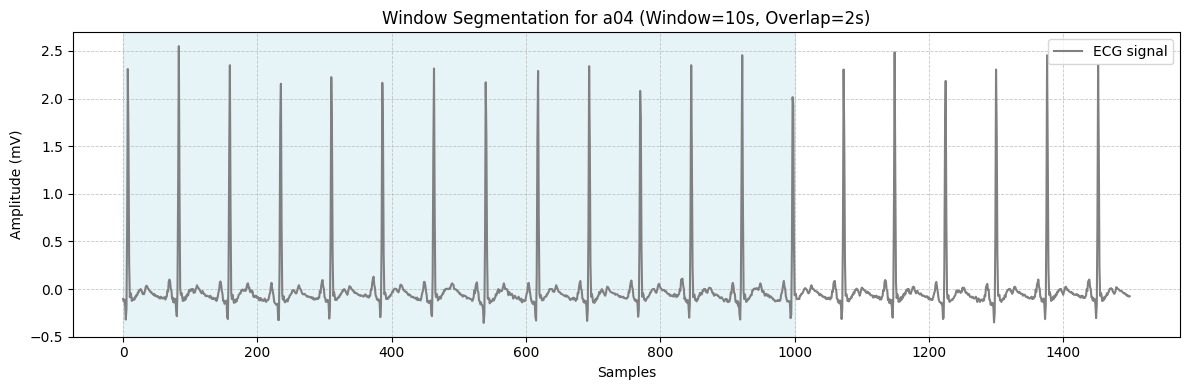

Total segments for a06: 3822


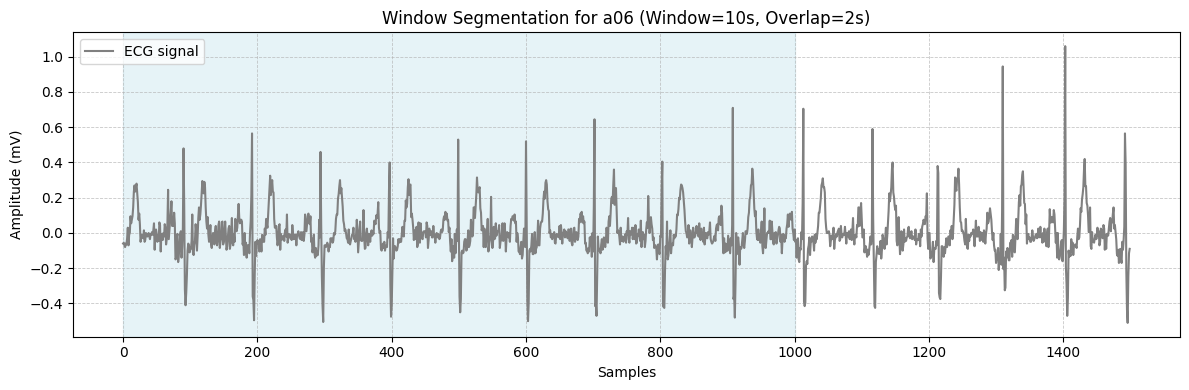

Total segments for b05: 3241


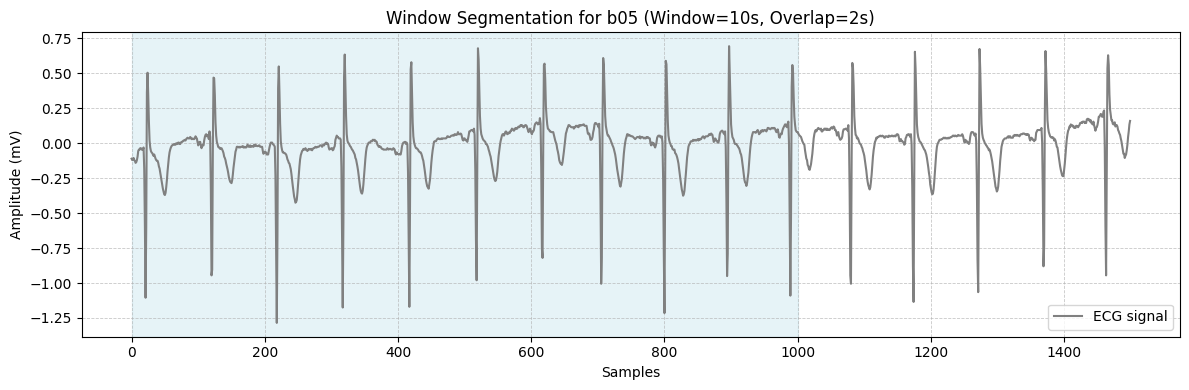

Total segments for a08: 3752


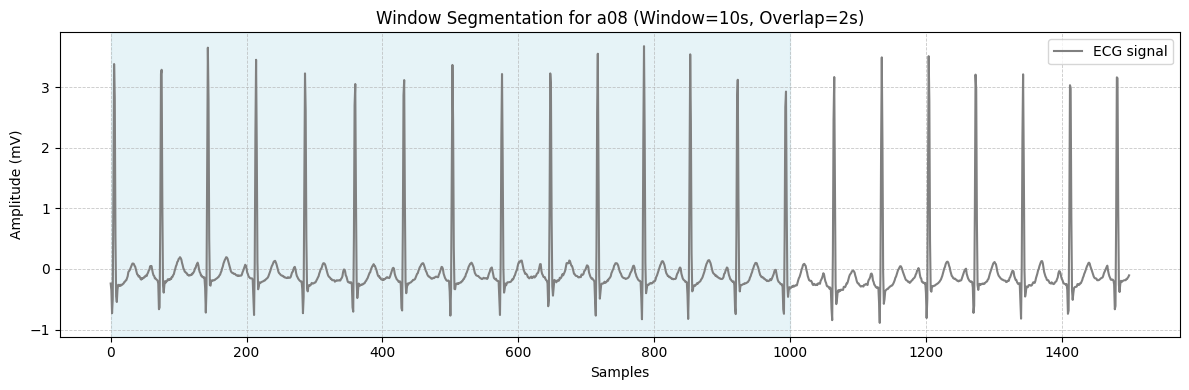

Total segments for c10: 3230


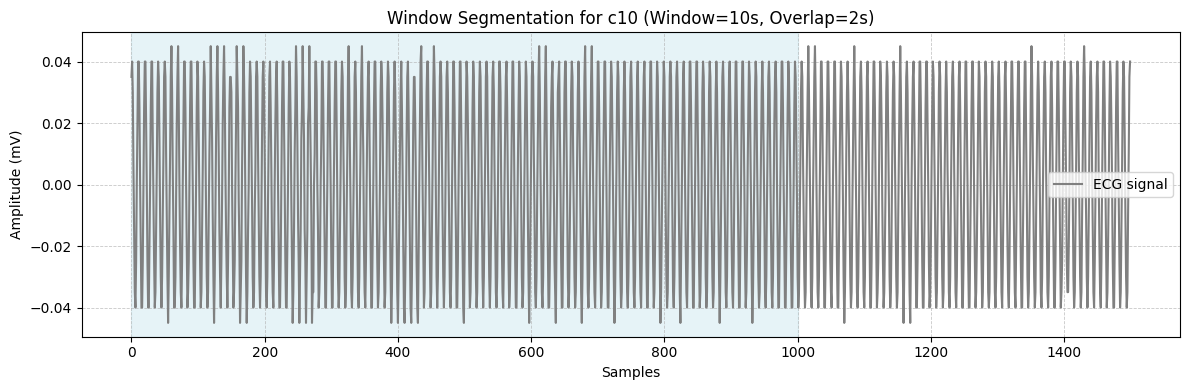

In [50]:
window_sec = 10   # seconds per window
overlap_sec = 2   # seconds overlap

def plot_windows(signal, fs, ws, overlap, subject):
    plt.figure(figsize=(12, 4))
    plt.plot(signal[:fs*15], color='gray', label='ECG signal')

    # Draw segmentation spans
    step = int(fs * (ws - overlap))
    for i in range(0, int(fs*15 - fs*ws), step):
        plt.axvspan(i, i + fs*ws, color='lightblue', alpha=0.3)

    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

    # Add titles and labels
    plt.title(f'Window Segmentation for {subject} (Window={ws}s, Overlap={overlap}s)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.tight_layout()
    plt.show()

for subj in subjects:
    sig = records[subj]['signal']
    fs = records[subj]['fs']

    # Perform segmentation
    segments = segment_signal(sig, fs, window_sec, overlap_sec)

    # Print total number of segments
    print(f"Total segments for {subj}: {len(segments)}")

    # Visualize window segmentation
    plot_windows(sig, fs, window_sec, overlap_sec, subj)

In [51]:
def segment_signal(signal, fs, window_sec, overlap_sec):
    window_size = int(window_sec * fs)
    step = int((window_sec - overlap_sec) * fs)
    if step <= 0:
        raise ValueError(f"Invalid combination: window={window_sec}s, overlap={overlap_sec}s → step={step}")
    segments = []
    for start in range(0, len(signal) - window_size, step):
        seg = signal[start:start + window_size]
        segments.append(seg)
    return np.array(segments)


In [52]:
def stability_analysis(signal, fs, window_lengths, overlaps):
    stability = {}
    for ws in window_lengths:
        for ov in overlaps:
            if ov >= ws:
                # Skip if overlap >= window
                continue
            segments = segment_signal(signal, fs, ws, ov)
            means = [np.mean(s) for s in segments]
            stability[(ws, ov)] = np.std(means)
    return stability

window_lengths = [5, 10, 15, 20, 30]
overlaps = [1, 2, 5, 10]

for subj in subjects:
    sig = records[subj]['signal']
    fs = records[subj]['fs']

    stability = stability_analysis(sig, fs, window_lengths, overlaps)

    # Convert to DataFrame
    stab_df = pd.DataFrame(list(stability.items()), columns=['(window, overlap)', 'std_mean'])

    print(f"\nSubject: {subj}")
    print(stab_df.head())


Subject: a04
  (window, overlap)  std_mean
0            (5, 1)  0.017199
1            (5, 2)  0.017303
2           (10, 1)  0.012172
3           (10, 2)  0.011466
4           (10, 5)  0.011766

Subject: a06
  (window, overlap)  std_mean
0            (5, 1)  0.005586
1            (5, 2)  0.005606
2           (10, 1)  0.003691
3           (10, 2)  0.003832
4           (10, 5)  0.003766

Subject: b05
  (window, overlap)  std_mean
0            (5, 1)  0.907036
1            (5, 2)  0.913923
2           (10, 1)  0.776782
3           (10, 2)  0.755288
4           (10, 5)  0.760689

Subject: a08
  (window, overlap)  std_mean
0            (5, 1)  0.278709
1            (5, 2)  0.279607
2           (10, 1)  0.215970
3           (10, 2)  0.211081
4           (10, 5)  0.213265

Subject: c10
  (window, overlap)  std_mean
0            (5, 1)  0.027464
1            (5, 2)  0.028236
2           (10, 1)  0.018810
3           (10, 2)  0.018363
4           (10, 5)  0.018443


In [53]:
# Define apnea labels
normal_labels = ['N']   # Normal breathing
apnea_labels = ['A']    # Apnea event

def label_apnea(annotation):
    """Convert apnea-ecg annotations into binary labels."""
    labels = []
    for sym in annotation.symbol:
        if sym in normal_labels:
            labels.append(0)  # Normal
        elif sym in apnea_labels:
            labels.append(1)  # Apnea
        else:
            # Unknown or unclassified symbol
            labels.append(np.nan)
    return np.array(labels)

# Example usage
#data_path = '/Users/mohithreddy/apnea-ecg-database-1.0.0'
ann = wfdb.rdann(os.path.join(data_path, 'a01'), 'apn')
apnea_labels = label_apnea(ann)

# Print summary of labels
unique, counts = np.unique(apnea_labels[~np.isnan(apnea_labels)], return_counts=True)
print("Apnea-ECG Labels Summary:", dict(zip(unique.astype(int), counts)))

Apnea-ECG Labels Summary: {0: 19, 1: 470}


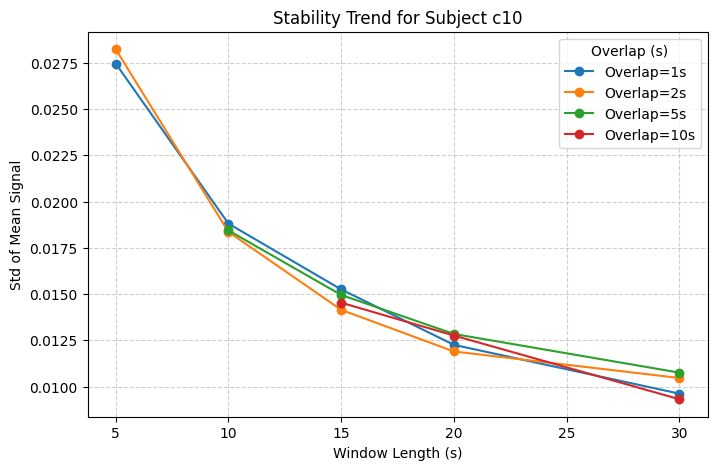

In [54]:
# Step 7 (fixed): Visualize stability to identify optimal window
plt.figure(figsize=(8,5))

for ov in overlaps:
    # Filter only valid window lengths that exist for this overlap
    valid_ws = [ws for ws in window_lengths if (ws, ov) in stability]
    vals = [stability[(ws, ov)] for ws in valid_ws]
    
    plt.plot(valid_ws, vals, marker='o', label=f'Overlap={ov}s')

plt.title(f'Stability Trend for Subject {subj}')
plt.xlabel('Window Length (s)')
plt.ylabel('Std of Mean Signal')
plt.legend(title='Overlap (s)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [55]:
# Step: Count number of windows for each subject and window size

window_sizes = [5, 10, 15, 20, 30]   # in seconds
overlap = 2                          # overlap in seconds

# Dictionary to store results: {subject: {window_size: count}}
window_counts = {}

for subj in subjects:
    sig = records[subj]['signal']
    fs = records[subj]['fs']
    subj_counts = {}  # inner dictionary for each subject

    for ws in window_sizes:
        if ws <= overlap:
            continue  # skip invalid pairs where overlap >= window
        segs = segment_signal(sig, fs, ws, overlap)
        subj_counts[ws] = len(segs)
        print(f"{subj} — Window {ws}s → {len(segs)} segments")

    window_counts[subj] = subj_counts
window_df = pd.DataFrame(window_counts).T  # rows = subjects, cols = window sizes
window_df

a04 — Window 5s → 9932 segments
a04 — Window 10s → 3724 segments
a04 — Window 15s → 2292 segments
a04 — Window 20s → 1655 segments
a04 — Window 30s → 1064 segments
a06 — Window 5s → 10192 segments
a06 — Window 10s → 3822 segments
a06 — Window 15s → 2352 segments
a06 — Window 20s → 1698 segments
a06 — Window 30s → 1092 segments
b05 — Window 5s → 8644 segments
b05 — Window 10s → 3241 segments
b05 — Window 15s → 1994 segments
b05 — Window 20s → 1440 segments
b05 — Window 30s → 926 segments
a08 — Window 5s → 10007 segments
a08 — Window 10s → 3752 segments
a08 — Window 15s → 2309 segments
a08 — Window 20s → 1667 segments
a08 — Window 30s → 1072 segments
c10 — Window 5s → 8615 segments
c10 — Window 10s → 3230 segments
c10 — Window 15s → 1988 segments
c10 — Window 20s → 1435 segments
c10 — Window 30s → 923 segments


,5,10,15,20,30
a04,9932,3724,2292,1655,1064
a06,10192,3822,2352,1698,1092
b05,8644,3241,1994,1440,926
a08,10007,3752,2309,1667,1072
c10,8615,3230,1988,1435,923


In [56]:
results = {}

for rec in ['a04', 'a06', 'b05', 'a08', 'c10']:
    signal = records[rec]['signal']
    segs = segment_signal(signal, fs, window_sec=10, overlap_sec=0.2)
    results[rec] = segs
    print(f"Record {rec}: {len(segs)} windows created (10s window, 2s overlap)")


Record a04: 3040 windows created (10s window, 2s overlap)
Record a06: 3120 windows created (10s window, 2s overlap)
Record b05: 2646 windows created (10s window, 2s overlap)
Record a08: 3063 windows created (10s window, 2s overlap)
Record c10: 2637 windows created (10s window, 2s overlap)


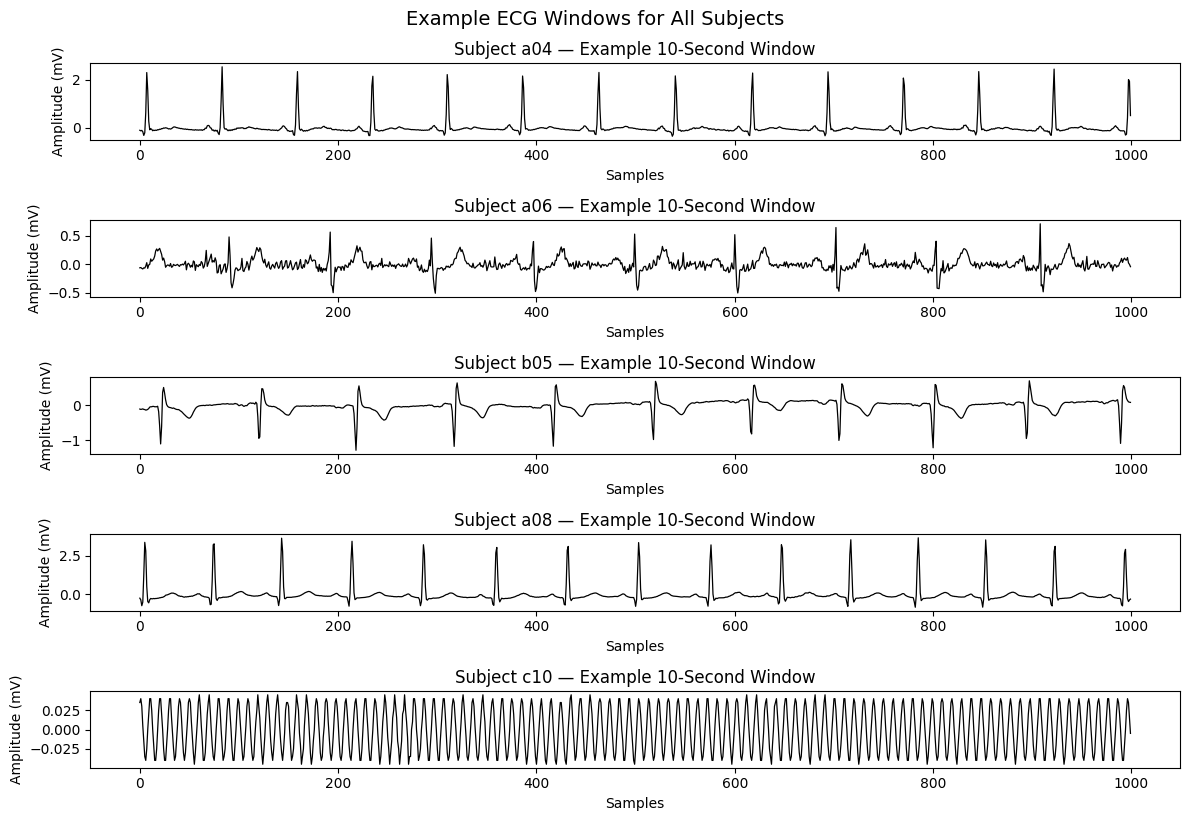

In [57]:
plt.figure(figsize=(12, 8))

# loop through each subject and plot their first window
for i, rec in enumerate(results.keys(), start=1):
    plt.subplot(len(results), 1, i)  # create one subplot per subject
    plt.plot(results[rec][0], color='black', linewidth=0.9)
    plt.title(f"Subject {rec} — Example 10-Second Window")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.tight_layout()

plt.suptitle("Example ECG Windows for All Subjects", fontsize=14, y=1.02)
plt.show()

# Step 2

In [58]:
def extract_features(windows, fs):
    """Extract statistical, frequency, and HRV features from ECG windows."""
    from scipy.fft import rfft, rfftfreq
    feats = []
    for w in windows:
        min_val = np.min(w)
        max_val = np.max(w)
        amp = max_val - min_val
        mean_val = np.mean(w)
        std_val = np.std(w)
        skew_val = skew(w)
        kurt_val = kurtosis(w)

        # Frequency domain features
        freqs = rfftfreq(len(w), 1/fs)
        spectrum = np.abs(rfft(w))
        dom_freq = freqs[np.argmax(spectrum)]
        power = np.sum(spectrum**2)
        entropy = -np.sum((spectrum/power)*np.log((spectrum/power)+1e-10))

        # HRV-like features
        peaks, _ = find_peaks(w, distance=fs*0.4)
        rr = np.diff(peaks)/fs if len(peaks) > 1 else [0]
        mean_rr, sdnn = np.mean(rr), np.std(rr)

        feats.append([
            min_val, max_val, amp, mean_val, std_val, skew_val, kurt_val,
            dom_freq, power, entropy, mean_rr, sdnn
        ])

    cols = ['Min','Max','Amplitude','Mean','Std','Skew','Kurtosis',
            'DomFreq','Power','Entropy','MeanRR','SDNN']
    return pd.DataFrame(feats, columns=cols)


In [59]:
# Step 3: Extract features for all segments of one subject
def extract_features_for_subject(signal, fs, window_size, overlap):
    segments = segment_signal(signal, fs, window_size, overlap)
    all_features = []

    for seg in segments:
        feat = extract_features_from_window(seg, fs)
        all_features.append(feat)

    df_features = pd.DataFrame(all_features)
    return df_features


In [60]:
window_labels = assign_window_labels(records, fs=100, window_sec=10, overlap_sec=2)

all_feature_tables = []

for subj in subjects:
    signal = records[subj]['filtered']
    fs = records[subj]['fs']
    
    # Segment the ECG
    windows = segment_signal(signal, fs, window_sec=10, overlap_sec=2)
    
    # Extract features
    df_feat = extract_features(windows, fs)
    
    # Align window labels and features (fixes ValueError)
    n = min(len(df_feat), len(window_labels[subj]))
    df_feat = df_feat.iloc[:n].copy()
    df_feat['Target'] = window_labels[subj][:n]
    
    # Add subject ID
    df_feat['Subject_ID'] = subj
    
    all_feature_tables.append(df_feat)
    print(f"{subj}: {len(df_feat)} windows × {df_feat.shape[1]} features extracted")

# Combine all subjects into one DataFrame
combined_features = pd.concat(all_feature_tables, ignore_index=True)
combined_features = combined_features.dropna(subset=['Target']).reset_index(drop=True)
print(f"\n Combined feature table created — Shape: {combined_features.shape}")

a04: 3723 window labels generated.
a06: 3821 window labels generated.
b05: 3240 window labels generated.
a08: 3751 window labels generated.
c10: 3230 window labels generated.
a04: 3723 windows × 14 features extracted
a06: 3821 windows × 14 features extracted
b05: 3240 windows × 14 features extracted
a08: 3751 windows × 14 features extracted
c10: 3230 windows × 14 features extracted

 Combined feature table created — Shape: (17765, 14)


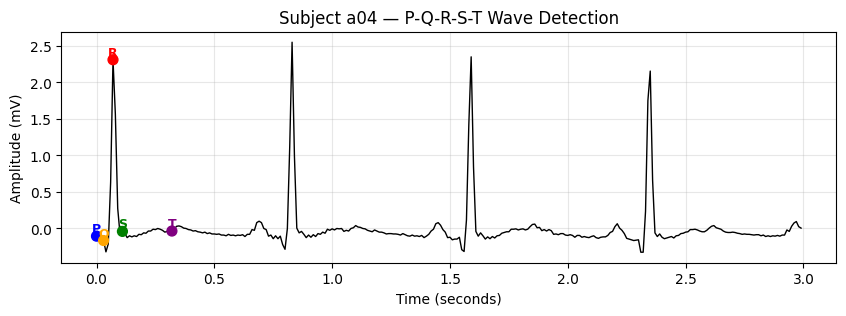

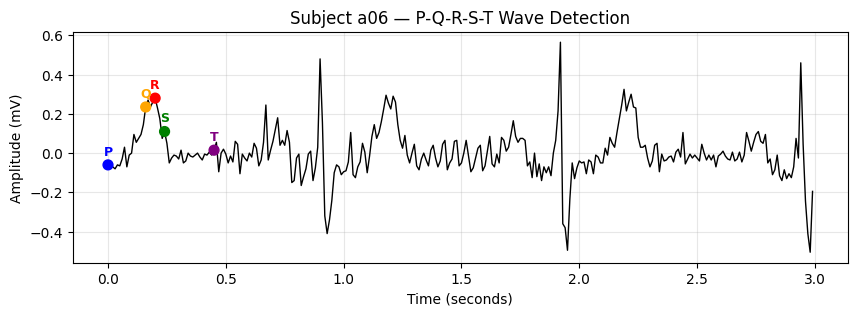

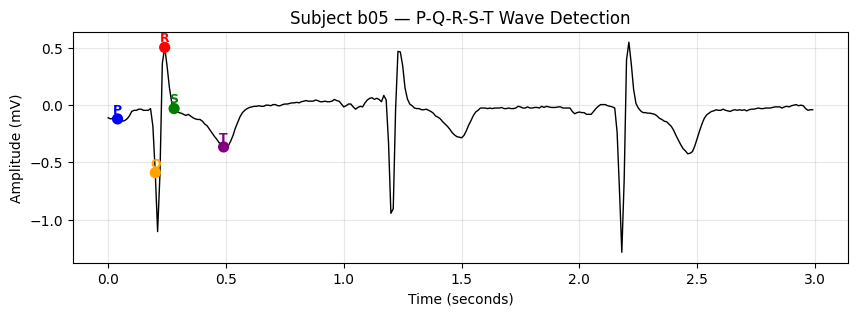

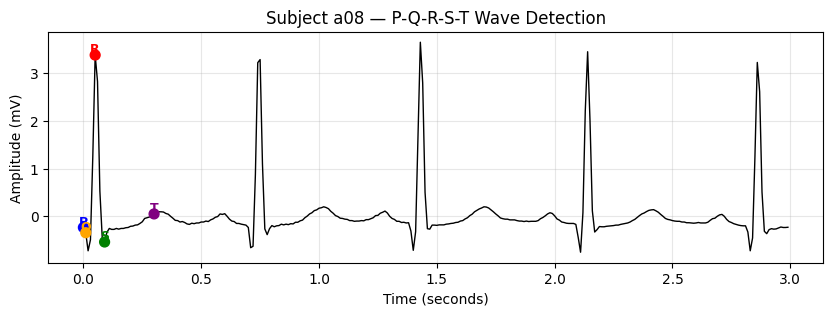

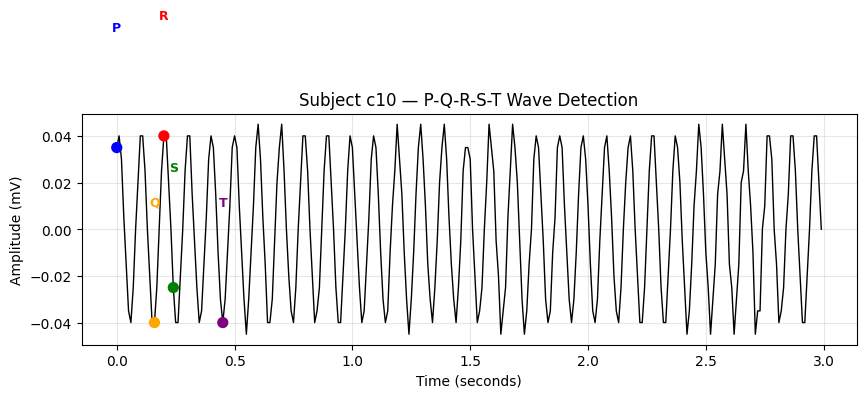


Extracted PQRST Amplitude and Interval Features for 5 Subjects:

  Subject_ID  P_amp  Q_amp  R_amp  S_amp  T_amp  PR_interval  QRS_duration  \
0        a04 -0.105 -0.165  2.310 -0.040 -0.035         0.07          0.08   
1        a06 -0.060  0.235  0.280  0.110  0.015         0.20          0.08   
2        b05 -0.120 -0.590  0.505 -0.030 -0.365         0.20          0.08   
3        a08 -0.240 -0.350  3.385 -0.545  0.045         0.05          0.08   
4        c10  0.035 -0.040  0.040 -0.025 -0.040         0.20          0.08   

   QT_interval  
0         0.29  
1         0.29  
2         0.29  
3         0.29  
4         0.29  


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

fs = 100  # sampling frequency (Hz)

def analyze_and_plot_pqrst(signal, fs, subject_id, duration=3):
    """
    Detects P, Q, R, S, and T waves in an ECG signal segment,
    plots them, and returns amplitude & interval features.
    """
    segment = signal[:fs*duration]
    time_axis = np.arange(len(segment)) / fs

    # Detect R-peaks (dominant spikes)
    r_peaks, _ = find_peaks(segment, distance=fs*0.4, height=np.mean(segment)+0.2*np.std(segment))

    # Initialize
    p_amp = q_amp = r_amp = s_amp = t_amp = np.nan
    pr_interval = qrs_duration = qt_interval = np.nan
    p_idx = q_idx = r_idx = s_idx = t_idx = None

    if len(r_peaks) > 0:
        r_idx = r_peaks[0]
        r_amp = segment[r_idx]

        # Approximate other wave positions relative to R
        p_idx = max(0, r_idx - int(0.2 * fs))
        q_idx = max(0, r_idx - int(0.04 * fs))
        s_idx = min(len(segment) - 1, r_idx + int(0.04 * fs))
        t_idx = min(len(segment) - 1, r_idx + int(0.25 * fs))

        p_amp, q_amp, s_amp, t_amp = segment[p_idx], segment[q_idx], segment[s_idx], segment[t_idx]

        pr_interval = (r_idx - p_idx) / fs
        qrs_duration = (s_idx - q_idx) / fs
        qt_interval = (t_idx - q_idx) / fs

        # ---- Plot ----
        plt.figure(figsize=(10, 3))
        plt.plot(time_axis, segment, color='black', linewidth=1)
        plt.title(f"Subject {subject_id} — P-Q-R-S-T Wave Detection")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(alpha=0.3)

        plt.scatter(time_axis[[p_idx, q_idx, r_idx, s_idx, t_idx]],
                    segment[[p_idx, q_idx, r_idx, s_idx, t_idx]],
                    color=['blue', 'orange', 'red', 'green', 'purple'],
                    s=50, zorder=3)

        labels = ['P', 'Q', 'R', 'S', 'T']
        for idx, label, color in zip([p_idx, q_idx, r_idx, s_idx, t_idx],
                                     labels,
                                     ['blue', 'orange', 'red', 'green', 'purple']):
            plt.text(time_axis[idx], segment[idx] + 0.05, label,
                     color=color, fontsize=9, ha='center', fontweight='bold')
        plt.show()

    # Return numerical features
    return {
        'Subject_ID': subject_id,
        'P_amp': p_amp, 'Q_amp': q_amp, 'R_amp': r_amp, 'S_amp': s_amp, 'T_amp': t_amp,
        'PR_interval': pr_interval, 'QRS_duration': qrs_duration, 'QT_interval': qt_interval
    }


subjects = ['a04', 'a06', 'b05', 'a08', 'c10']
results = []

for rec in subjects:
    signal = records[rec]['signal']
    features = analyze_and_plot_pqrst(signal, fs, rec, duration=3)
    results.append(features)

# Convert to DataFrame for a clean summary
df_pqrst_summary = pd.DataFrame(results)
print("\nExtracted PQRST Amplitude and Interval Features for 5 Subjects:\n")
print(df_pqrst_summary.round(4))


# Step 3

In [62]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = combined_features.drop(columns=['Target', 'Subject_ID'])
y = combined_features['Target'].astype(int)

# Scale + Balance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

print("After SMOTE balancing:", np.bincount(y_res))


After SMOTE balancing: [16410 16410]


In [63]:
# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',solver='adam', max_iter=800, random_state=42)
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('mlp', mlp)],voting='soft')
ensemble.fit(X_res, y_res)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         n_estimators=200)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(64, 32),
                                            max_iter=800, random_state=42))],
                 voting='soft')

In [65]:
model = MLPClassifier(
    hidden_layer_sizes=(10,), # single hidden layer
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)


Classification Report:
               precision    recall  f1-score   support

           0      0.923     0.764     0.836     16410
           1      0.799     0.936     0.862     16410

    accuracy                          0.850     32820
   macro avg      0.861     0.850     0.849     32820
weighted avg      0.861     0.850     0.849     32820

AUC: 0.9220525563513576


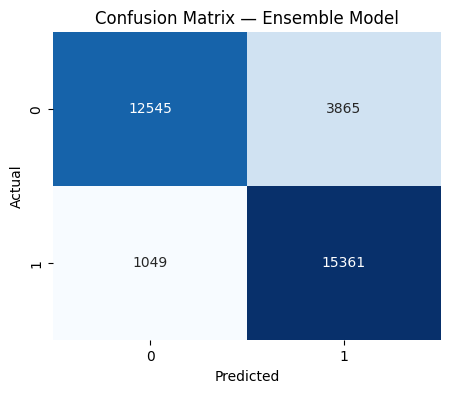

In [66]:
# After SMOTE
X_res, y_res = sm.fit_resample(X_scaled, y)

# Scale the resampled data if not done already
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

# Train on the balanced dataset
ensemble.fit(X_res_scaled, y_res)

# Predict on the same balanced data
y_pred = ensemble.predict(X_res_scaled)
y_prob = ensemble.predict_proba(X_res_scaled)[:, 1]

# Evaluate
print("\nClassification Report:\n", classification_report(y_res, y_pred, digits=3))
print("AUC:", roc_auc_score(y_res, y_prob))

cm = confusion_matrix(y_res, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix — Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


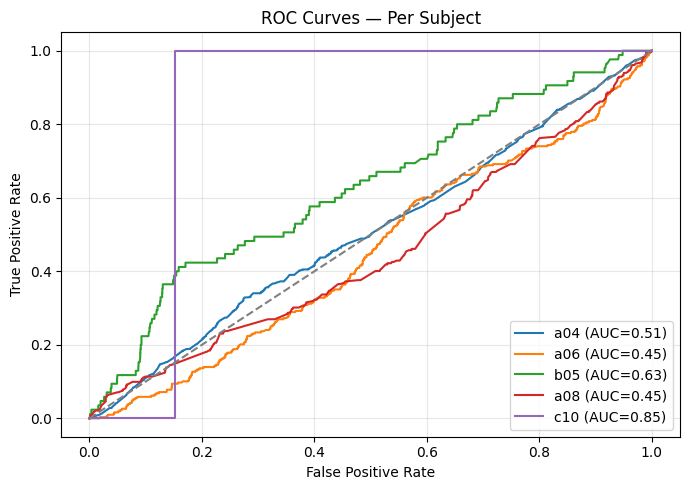

,Subject_ID,Accuracy,F1_Score,AUC
0,a04,0.288,0.301,0.506
1,a06,0.717,0.083,0.452
2,b05,0.820,0.107,0.626
3,a08,0.142,0.132,0.452
4,c10,0.025,0.001,0.848


In [67]:
subject_results = []

plt.figure(figsize=(7,5))

for subj in subjects:
    # Filter for one subject and remove missing Target values
    sub_df = combined_features[combined_features['Subject_ID'] == subj].dropna(subset=['Target'])
    
    if sub_df.empty:
        print(f"Skipping {subj} — no valid Target data.")
        continue

    # Extract features and scale
    X_raw = sub_df.drop(columns=['Subject_ID', 'Target'])
    X_sub = scaler.transform(X_raw)
    y_sub = sub_df['Target'].astype(int)

    # Clean scaled data: handle NaN, inf, and extreme values
    X_sub = np.nan_to_num(X_sub, nan=np.nan, posinf=np.nan, neginf=np.nan)
    imputer = SimpleImputer(strategy='mean')
    X_sub = imputer.fit_transform(X_sub)
    X_sub = np.clip(X_sub, -1e6, 1e6)

    try:
        # Predictions
        y_pred = ensemble.predict(X_sub)
        y_prob = ensemble.predict_proba(X_sub)[:, 1]

        # Metrics
        acc = accuracy_score(y_sub, y_pred)
        f1 = f1_score(y_sub, y_pred)
        auc_val = roc_auc_score(y_sub, y_prob)

        subject_results.append({
            'Subject_ID': subj,
            'Accuracy': round(acc, 3),
            'F1_Score': round(f1, 3),
            'AUC': round(auc_val, 3)
        })

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_sub, y_prob)
        plt.plot(fpr, tpr, lw=1.5, label=f"{subj} (AUC={auc_val:.2f})")

    except ValueError as e:
        print(f"Skipping {subj} due to error: {e}")

# Combined ROC visualization
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Per Subject")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display metrics as a DataFrame
results_df = pd.DataFrame(subject_results)
display(results_df)


 Per-Subject Performance Summary:



,Subject_ID,Accuracy,F1_Score,AUC
0,a04,0.288,0.301,0.506
1,a06,0.717,0.083,0.452
2,b05,0.820,0.107,0.626
3,a08,0.142,0.132,0.452
4,c10,0.025,0.001,0.848


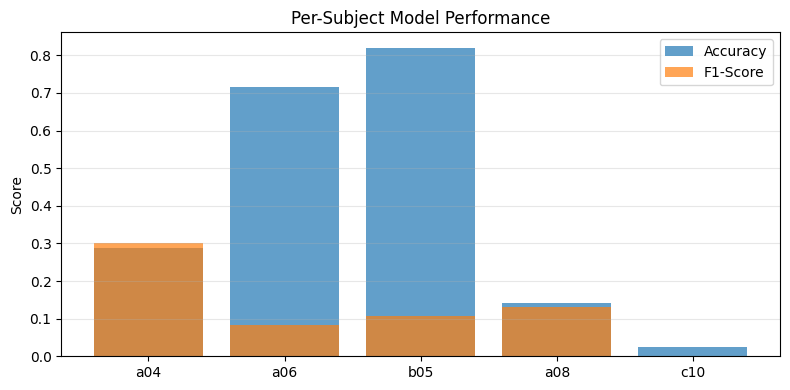

In [68]:
# Display subject metrics
subject_results_df = pd.DataFrame(subject_results)
print("\n Per-Subject Performance Summary:\n")
display(subject_results_df)

plt.figure(figsize=(8,4))
plt.bar(subject_results_df['Subject_ID'], subject_results_df['Accuracy'], label='Accuracy', alpha=0.7)
plt.bar(subject_results_df['Subject_ID'], subject_results_df['F1_Score'], label='F1-Score', alpha=0.7)
plt.title('Per-Subject Model Performance')
plt.ylabel('Score')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


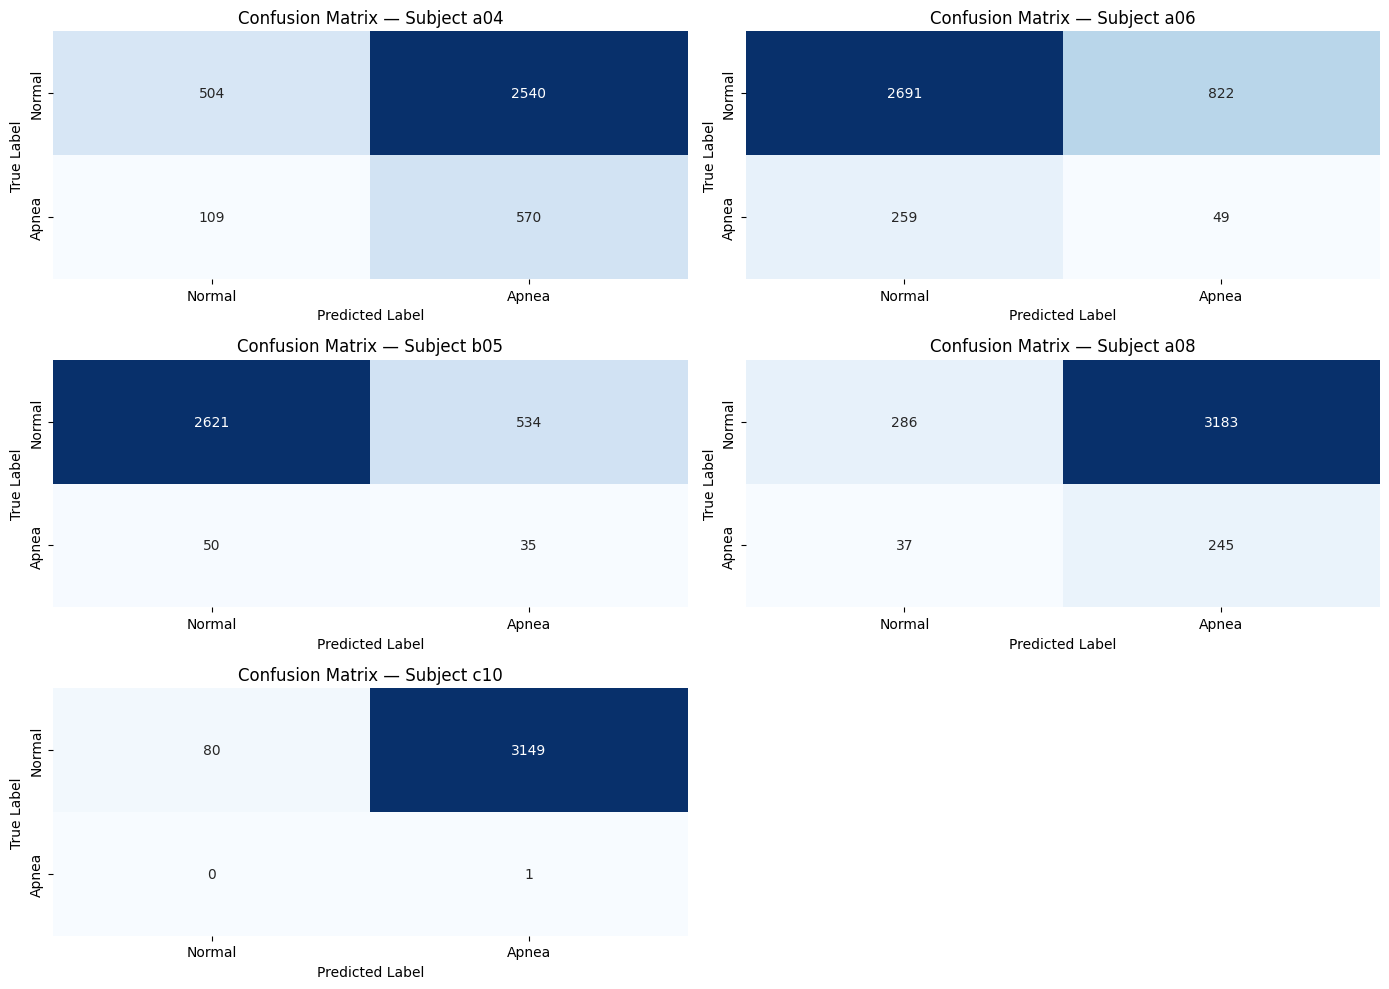

In [69]:
plt.figure(figsize=(14, 10))
plot_index = 1

for subj in ['a04', 'a06', 'b05', 'a08', 'c10']:
    sub_df = combined_features[combined_features['Subject_ID'] == subj].dropna(subset=['Target'])
    if sub_df.empty:
        print(f"Skipping {subj} — no valid data.")
        continue

    # Extract features and scale
    X_sub = sub_df.drop(columns=['Subject_ID', 'Target'])
    y_sub = sub_df['Target'].astype(int)
    X_sub_scaled = scaler.transform(X_sub)

    # --- CLEAN invalid values ---
    # Replace inf/-inf with NaN, then impute with mean
    X_sub_scaled = np.where(np.isfinite(X_sub_scaled), X_sub_scaled, np.nan)
    imputer = SimpleImputer(strategy='mean')
    X_sub_scaled = imputer.fit_transform(X_sub_scaled)

    # Clip extreme outliers that might cause float32 overflow
    X_sub_scaled = np.clip(X_sub_scaled, -1e6, 1e6)

    # Predict safely
    y_pred = ensemble.predict(X_sub_scaled)

    # Compute confusion matrix
    cm = confusion_matrix(y_sub, y_pred)

    # Plot
    plt.subplot(3, 2, plot_index)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Apnea'],
                yticklabels=['Normal', 'Apnea'])
    plt.title(f"Confusion Matrix — Subject {subj}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plot_index += 1

plt.tight_layout()
plt.show()

# Optional

/Users/mohithreddy/miniconda3/envs/av/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


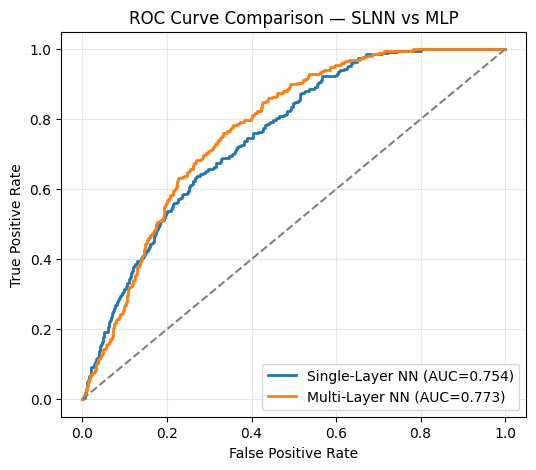

,Model,Accuracy,Precision,Recall,F1,AUC
0,Single-Layer NN,0.9237,0.0,0.0,0.0,0.7537
1,Multi-Layer NN,0.9234,0.0,0.0,0.0,0.7727


In [34]:
# Base dataset
X = combined_features.drop(columns=['Target', 'Subject_ID'])
y = combined_features['Target'].astype(int)

# Train/test split + scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Two models
models = {
    "Single-Layer NN": MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=500, random_state=42),
    "Multi-Layer NN":  MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.001, learning_rate='adaptive', max_iter=1000, random_state=42)
}

comparison = []
plt.figure(figsize=(6,5))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    comparison.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    })
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison — SLNN vs MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

comparison_df = pd.DataFrame(comparison)
display(comparison_df.round(4))

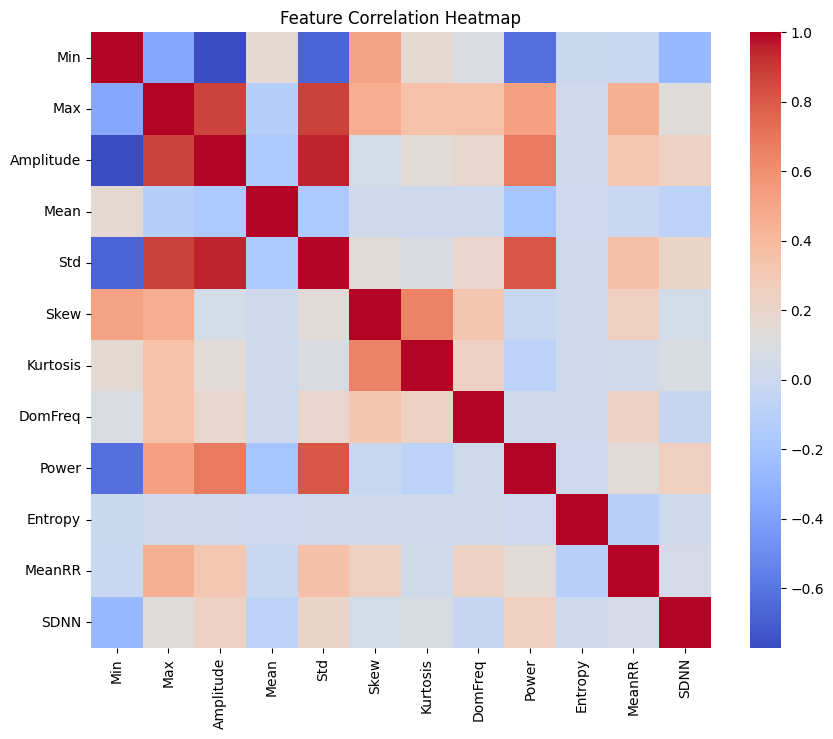

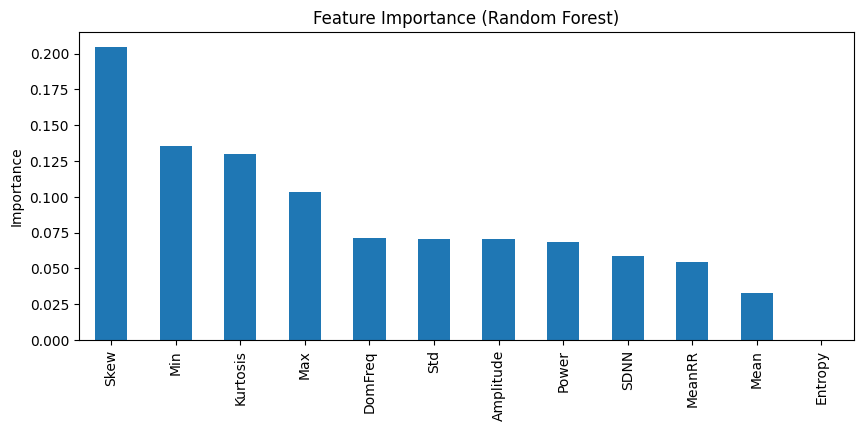

In [35]:
plt.figure(figsize=(10,8))
corr = pd.DataFrame(X_scaled, columns=X.columns).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Feature importance using Random Forest ---
rf.fit(X_res, y_res)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.show()

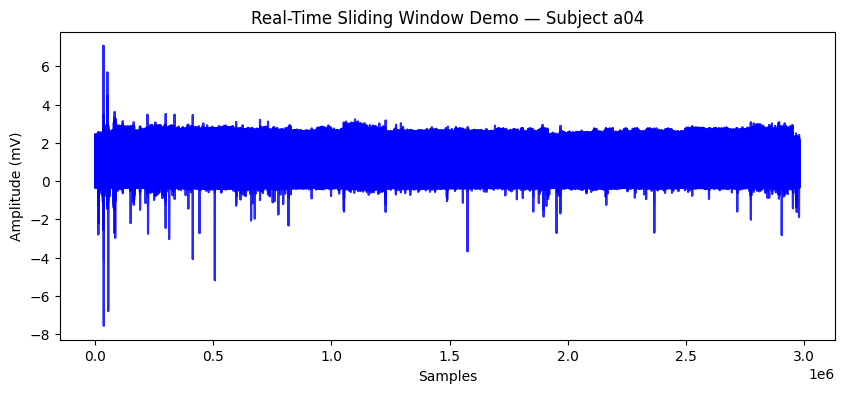

In [36]:
sample_subject = 'a04'
sig = records[sample_subject]['filtered']
fs = records[sample_subject]['fs']
window_sec = 10
overlap_sec = 2

plt.figure(figsize=(10,4))
plt.title(f"Real-Time Sliding Window Demo — Subject {sample_subject}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")

for i in range(0, len(sig) - fs*window_sec, fs*overlap_sec):
    segment = sig[i:i+fs*window_sec]
    plt.plot(range(i, i+len(segment)), segment, color='blue', alpha=0.3)
plt.show()